<a href="https://colab.research.google.com/github/aounallahsara/ML_models/blob/main/R%C3%A9seau_Bay%C3%A9sien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pgmpy==0.1.19

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pgmpy

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_raw = pd.read_csv('/content/drive/MyDrive/Titanic-Dataset.csv')

In [5]:
df_raw.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_raw.shape

(891, 12)

In [7]:
titanic = df_raw.copy()
titanic = titanic.drop(['PassengerId','Ticket', 'Cabin', 'Name'],axis=1)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [8]:
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].mean())
titanic['Embarked'] = titanic['Embarked'].fillna(titanic['Embarked'].mode()[0])

In [9]:
print(titanic.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


Discrétisation

In [10]:
titanic['Age_dic'] = pd.cut(titanic['Age'], bins=[0,12,60,120], labels=['child','adult','senior'])

In [11]:
titanic['Fare_dic'] = pd.qcut(titanic['Fare'], q=3, labels=['low','med','high'])

In [12]:
titanic['family_size'] = titanic['SibSp'] + titanic['Parch']
titanic['family_size_dic'] = pd.cut(titanic['family_size'], bins=[-1,0,2,5,50], labels=['alone','small','medium','large'])

In [13]:
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_dic,Fare_dic,family_size,family_size_dic
0,0,3,male,22.000000,1,0,7.2500,S,adult,low,1,small
1,1,1,female,38.000000,1,0,71.2833,C,adult,high,1,small
2,1,3,female,26.000000,0,0,7.9250,S,adult,low,0,alone
3,1,1,female,35.000000,1,0,53.1000,S,adult,high,1,small
4,0,3,male,35.000000,0,0,8.0500,S,adult,low,0,alone
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,adult,med,0,alone
887,1,1,female,19.000000,0,0,30.0000,S,adult,high,0,alone
888,0,3,female,29.699118,1,2,23.4500,S,adult,med,3,medium
889,1,1,male,26.000000,0,0,30.0000,C,adult,high,0,alone


In [14]:
titanic_dic = titanic[['Survived', 'Pclass', 'Sex', 'Embarked', 'Age_dic', 'Fare_dic', 'family_size_dic']].copy()

In [15]:
titanic_dic

,Survived,Pclass,Sex,Embarked,Age_dic,Fare_dic,family_size_dic
0,0,3,male,S,adult,low,small
1,1,1,female,C,adult,high,small
2,1,3,female,S,adult,low,alone
3,1,1,female,S,adult,high,small
4,0,3,male,S,adult,low,alone
...,...,...,...,...,...,...,...
886,0,2,male,S,adult,med,alone
887,1,1,female,S,adult,high,alone
888,0,3,female,S,adult,med,medium
889,1,1,male,C,adult,high,alone


In [16]:
titanic_dic['Sex'] = titanic_dic['Sex'].map({'male':0, 'female':1})

In [17]:
col = ['Embarked', 'Age_dic', 'Fare_dic', 'family_size_dic']
titanic_dic = pd.get_dummies(titanic_dic, columns=col, dtype=int)

In [18]:
titanic_dic

,Survived,Pclass,Sex,Embarked_C,Embarked_Q,Embarked_S,Age_dic_child,Age_dic_adult,Age_dic_senior,Fare_dic_low,Fare_dic_med,Fare_dic_high,family_size_dic_alone,family_size_dic_small,family_size_dic_medium,family_size_dic_large
0,0,3,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,1,1,1,1,0,0,0,1,0,0,0,1,0,1,0,0
2,1,3,1,0,0,1,0,1,0,1,0,0,1,0,0,0
3,1,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0
4,0,3,0,0,0,1,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,1,0,1,0,0,1,0,1,0,0,0
887,1,1,1,0,0,1,0,1,0,0,0,1,1,0,0,0
888,0,3,1,0,0,1,0,1,0,0,1,0,0,0,1,0
889,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0


In [19]:

hc = HillClimbSearch(titanic_dic)

best_bic = hc.estimate(scoring_method=BicScore(titanic_dic))
best_k2 = hc.estimate(scoring_method=K2Score(titanic_dic))
best_bdeu = hc.estimate(scoring_method=BDeuScore(titanic_dic))

print("Edges (BIC):", best_bic)
print("Edges (BIC):", best_bic.edges())
print("Edges (K2):", best_k2)
print("Edges (K2):", best_k2.edges())
print("Edges (BDeu):", best_bdeu)
print("Edges (BDeu):", best_bdeu.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges (BIC): DAG with 16 nodes and 30 edges
Edges (BIC): [('Survived', 'Sex'), ('Survived', 'family_size_dic_small'), ('Pclass', 'Fare_dic_high'), ('Pclass', 'Fare_dic_low'), ('Pclass', 'Survived'), ('Pclass', 'Embarked_C'), ('Pclass', 'Embarked_Q'), ('Pclass', 'family_size_dic_large'), ('Embarked_C', 'Embarked_S'), ('Embarked_C', 'Embarked_Q'), ('Embarked_Q', 'Embarked_S'), ('Age_dic_child', 'Age_dic_senior'), ('Age_dic_adult', 'Age_dic_child'), ('Age_dic_adult', 'Age_dic_senior'), ('Fare_dic_low', 'Fare_dic_med'), ('Fare_dic_high', 'Fare_dic_low'), ('Fare_dic_high', 'Fare_dic_med'), ('Fare_dic_high', 'Embarked_C'), ('family_size_dic_alone', 'Fare_dic_low'), ('family_size_dic_alone', 'Fare_dic_high'), ('family_size_dic_alone', 'Age_dic_adult'), ('family_size_dic_alone', 'Sex'), ('family_size_dic_alone', 'Age_dic_child'), ('family_size_dic_small', 'family_size_dic_alone'), ('family_size_dic_small', 'Fare_dic_high'), ('family_size_dic_small', 'family_size_dic_medium'), ('family_size_dic

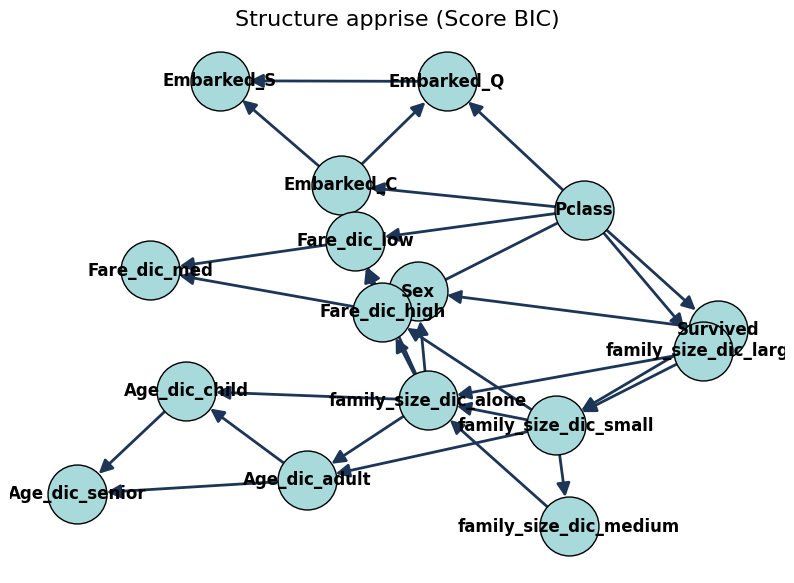

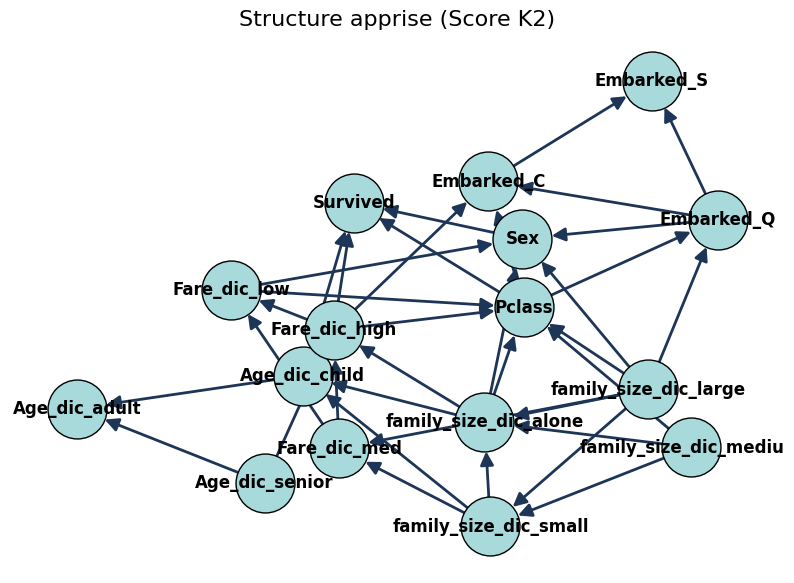

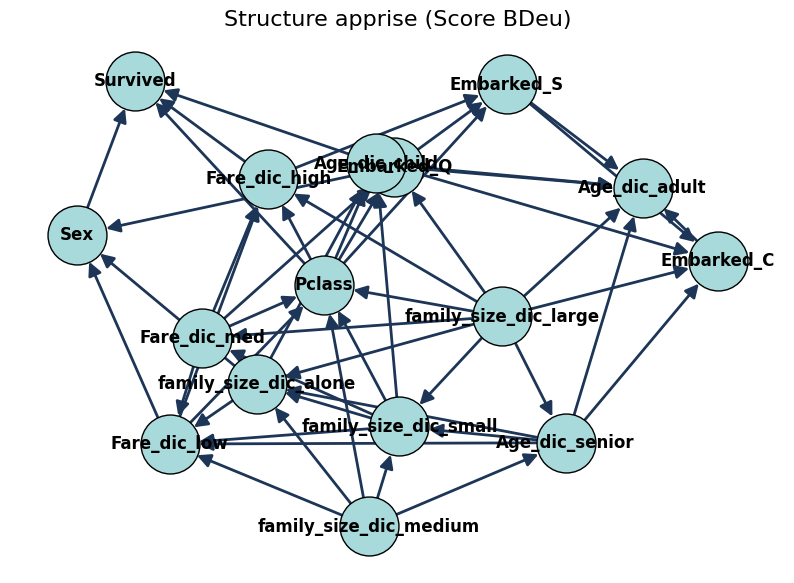

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_model_edges_clean(model, title):
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())


    pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(10, 7))


    nx.draw_networkx_nodes(
        G, pos,
        node_size=1800,
        node_color="#a8dadc",   # bleu clair
        edgecolors="black"
    )


    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=20,
        node_size=1800,
        width=2,
        edge_color="#1d3557"
    )

    nx.draw_networkx_labels(
        G, pos,
        font_size=12,
        font_weight='bold'
    )

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()


# Appel pour chaque structure
plot_model_edges_clean(best_bic, "Structure apprise (Score BIC)")
plot_model_edges_clean(best_k2, "Structure apprise (Score K2)")
plot_model_edges_clean(best_bdeu, "Structure apprise (Score BDeu)")


In [21]:
print("Colonnes du dataset (pour evidence):")
print(list(titanic_dic.columns))


!pip install "numpy<2.0.0" --force-reinstall


import numpy as np
import pandas as pd

import pgmpy
from pgmpy.models import BayesianNetwork # Changed from BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

def learn_and_inspect(model_structure, data, estimator="MLE", bayes_prior_type='BDeu', ess=5, model_name="model"):
    +

    if not isinstance(model_structure, BayesianNetwork):
        learned_model = BayesianNetwork(model_structure.edges())
    else:
        learned_model = model_structure


    if estimator == "MLE":
        learned_model.fit(data, estimator=MaximumLikelihoodEstimator)
    else:
        learned_model.fit(data, estimator=BayesianEstimator,
                          prior_type=bayes_prior_type,
                          equivalent_sample_size=ess)


    try:
        assert learned_model.check_model()
        print(f"[OK] {model_name} : modèle cohérent (check_model passed).")
    except Exception as e:
        print(f"[WARN] {model_name} : check_model a soulevé : {e}")

    # Afficher CPDs (quelques premiers si trop nombreux)
    cpds = learned_model.get_cpds()
    print(f"\n--- CPDs pour {model_name} (total {len(cpds)}) ---")
    for c in cpds:
        print(c)
        print()

    return learned_model

# Apprentissage des paramètres pour chaque structure
model_bic_mle  = learn_and_inspect(best_bic,  titanic_dic, estimator="MLE", model_name="BIC_MLE")
model_k2_bayes = learn_and_inspect(best_k2,   titanic_dic, estimator="Bayes", bayes_prior_type='BDeu', ess=10, model_name="K2_Bayesian")
model_bdeu_mle  = learn_and_inspect(best_bdeu, titanic_dic, estimator="MLE", model_name="BDeu_MLE")

Colonnes du dataset (pour evidence):
['Survived', 'Pclass', 'Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Age_dic_child', 'Age_dic_adult', 'Age_dic_senior', 'Fare_dic_low', 'Fare_dic_med', 'Fare_dic_high', 'family_size_dic_alone', 'family_size_dic_small', 'family_size_dic_medium', 'family_size_dic_large']
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
open

/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)

[WARN] BIC_MLE : check_model a soulevé : Sum or integral of conditional probabilites for node Fare_dic_high is not equal to 1.

--- CPDs pour BIC_MLE (total 16) ---
+-------------+---------------------+-----+---------------------+
| Pclass      | Pclass(1)           | ... | Pclass(3)           |
+-------------+---------------------+-----+---------------------+
| Survived(0) | 0.37037037037037035 | ... | 0.7576374745417516  |
+-------------+---------------------+-----+---------------------+
| Survived(1) | 0.6296296296296297  | ... | 0.24236252545824846 |
+-------------+---------------------+-----+---------------------+

+-----------------------+-----+--------------------------+
| Survived              | ... | Survived(1)              |
+-----------------------+-----+--------------------------+
| family_size_dic_alone | ... | family_size_dic_alone(1) |
+-----------------------+-----+--------------------------+
| Sex(0)                | ... | 0.39263803680981596      |
+-----------------

/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)).reshape(tabular_cpd.cardinality)
/usr/local/lib/python3.12/dist-packages/pgmpy/factors/discrete/CPD.py:332: RuntimeWarning: invalid value encountered in divide
  tabular_cpd.values = (cpd / cpd.sum(axis=0)